# Simple Model

[Tutorial](https://www.analyticsvidhya.com/blog/2019/07/learn-build-first-speech-to-text-model-python/)

* Load audio files into array
* No Feature Engineering
* Simple Conv1D Model

**Results**

Model (4 common labels):
* val_loss: 0.8760
* val_accuracy: 0.7200

Model (all labels):
* val_loss: 4.8854
* val_accuracy: 0.1263

## Imports

In [27]:
import os
from random import choice
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

## Parameters

In [28]:
path = 'C:/_data/GIZ_Audio'
path_audio = f'{path}/audio_files'

sample_rate=8000
sample_avg = 19680

## Load Data

In [29]:
files = os.listdir(path_audio)
file = files[0]

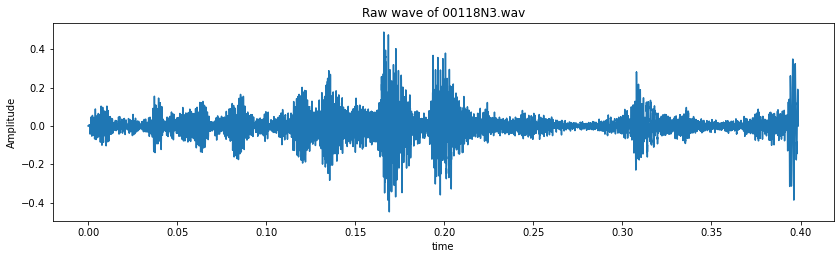

In [30]:
samples, sample_rate = librosa.load(f'{path_audio}/{file}', sr = sample_rate)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title(f'Raw wave of {file}')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')

ax1.plot(np.linspace(0, sample_rate/len(samples), len(samples)), samples);

In [31]:
print(sample_rate)
print(len(samples))
ipd.Audio(samples, rate=sample_rate)

8000
20063


In [32]:
file=choice(files)
print(file)
samples, sample_rate = librosa.load(f'{path_audio}/{file}', sr = sample_rate)

ipd.Audio(samples, rate=sample_rate)

A6W7P1E.wav


In [33]:
file=choice(files)
print(file)
samples, sample_rate = librosa.load(f'{path_audio}/{file}', sr = sample_rate)

ipd.Audio(samples, rate=sample_rate)

5aa4893526794a73a3ed0a7ebba2a7bf_a6a6b8d0d25c44ec9bcc6cecde61cd7f.wav


In [34]:
file=choice(files)
print(file)
samples, sample_rate = librosa.load(f'{path_audio}/{file}', sr = sample_rate)

ipd.Audio(samples, rate=sample_rate)

2497942026ef4d7e97d47fc2738d7c27_29af9533ca7d4bfa90d841decd24049a.wav


### Durations

In [35]:
duration_of_recordings = []
samples_of_recordings = []

for file in files[:100]:
    samples, sample_rate = librosa.load(f'{path_audio}/{file}', sr=sample_rate)
    duration_of_recordings.append(float(len(samples)/sample_rate))
    samples_of_recordings.append(len(samples))

In [36]:
np.median(duration_of_recordings)

2.46

In [37]:
np.max(duration_of_recordings)

2.52

In [38]:
np.median(samples_of_recordings)

19680.0

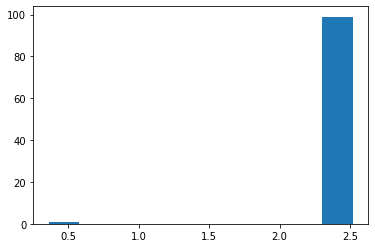

In [39]:
plt.hist(np.array(duration_of_recordings));

In [40]:
y_df = pd.read_csv(f'{path}/Train_ext.csv')
y_df['file'] = [x.replace('audio_files/', '') for x in y_df.fn]
files_label = y_df.file.to_list()

print(y_df.shape)
y_df.sample(5)

(2849, 3)


,fn,label,file
594,audio_files/I84MBYS.wav,muceere,I84MBYS.wav
846,audio_files/WI5ZXEO.wav,bibala,WI5ZXEO.wav
1917,audio_files/d45cd9903b3044d494866b3162651a76_8...,endwadde,d45cd9903b3044d494866b3162651a76_86fe198a05774...
982,audio_files/2QB56VF.wav,ebijjanjalo,2QB56VF.wav
588,audio_files/UC802DI.wav,okusiga,UC802DI.wav


In [41]:
pd.DataFrame(y_df.label.value_counts()).head(10)

,label
ebiwuka,32
okusaasaanya,31
endwadde,31
ndwadde,31
ebigimusa,31
okufuuyira,31
obusaanyi,31
ddagala,30
ensiringanyi,30
obuwuka,30


##  Subset Model (4 labels)

In [42]:
labels = ['ebiwuka', 'ndwadde', 'ddagala', 'okusaasaanya']

files_label = y_df[y_df.label.isin(labels)].file.to_list()
len(files_label)

124

In [43]:
x = []
f_short=[]
y = []

for file in files_label:
    
    samples, sample_rate = librosa.load(f'{path_audio}/{file}', sr = 8000)
    # samples = librosa.resample(y=samples, orig_sr=44100, target_sr=8000, fix=True)
    label = y_df.loc[y_df.file==file, 'label'].values[0]
    
    if(len(samples) > 19680):
        samples=samples[:19680]
    if(len(samples) < 19680):
        samples = np.pad(samples, [0, 19680-len(samples)])

    x.append(samples)
    y.append(label)
        
f'{len(x)}/{len(files_label)} ({np.round(len(x) / len(files_label),2)*100}%) of files processed'

'124/124 (100.0%) of files processed'

In [44]:
le = LabelEncoder()
y = le.fit_transform(y)
y = np.array(y)

classes = list(le.classes_)
len(classes)

4

In [45]:
y = to_categorical(y)
y.shape

(124, 4)

In [46]:
x = np.array(x).reshape(-1,19680,1)
x.shape

(124, 19680, 1)

In [47]:
x_trn, x_val, y_trn, y_val = train_test_split(x, y, stratify=y, test_size=0.2, random_state=777)
x_trn.shape, x_val.shape, y_trn.shape, y_val.shape

((99, 19680, 1), (25, 19680, 1), (99, 4), (25, 4))

### CNN Model

In [48]:
inputs = Input(shape=(19680,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(classes), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19680, 1)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 19668, 8)          112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6556, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 6556, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6546, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2182, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2182, 16)         

In [49]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [50]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [51]:
history = model.fit(x_trn, y_trn ,epochs=100, callbacks=[es,mc], batch_size=128, validation_data=(x_val,y_val))

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 1.4013 - accuracy: 0.1616
Epoch 00001: val_loss improved from inf to 1.35400, saving model to best_model.hdf5
1/1 [==============================] - 0s 333ms/step - loss: 1.4013 - accuracy: 0.1616 - val_loss: 1.3540 - val_accuracy: 0.2800
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 1.3092 - accuracy: 0.3939
Epoch 00002: val_loss improved from 1.35400 to 1.30386, saving model to best_model.hdf5
1/1 [==============================] - 0s 121ms/step - loss: 1.3092 - accuracy: 0.3939 - val_loss: 1.3039 - val_accuracy: 0.4000
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 1.2704 - accuracy: 0.4646
Epoch 00003: val_loss improved from 1.30386 to 1.27062, saving model to best_model.hdf5
1/1 [==============================] - 0s 126ms/step - loss: 1.2704 - accuracy: 0.4646 - val_loss: 1.2706 - val_accuracy: 0.4000
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 1.2845 

Epoch 29/100
1/1 [==============================] - ETA: 0s - loss: 0.5279 - accuracy: 0.7576
Epoch 00029: val_loss did not improve from 0.80819
1/1 [==============================] - 0s 47ms/step - loss: 0.5279 - accuracy: 0.7576 - val_loss: 0.9553 - val_accuracy: 0.6400
Epoch 30/100
1/1 [==============================] - ETA: 0s - loss: 0.5797 - accuracy: 0.7677
Epoch 00030: val_loss did not improve from 0.80819
1/1 [==============================] - 0s 55ms/step - loss: 0.5797 - accuracy: 0.7677 - val_loss: 0.9351 - val_accuracy: 0.6400
Epoch 31/100
1/1 [==============================] - ETA: 0s - loss: 0.6095 - accuracy: 0.7475
Epoch 00031: val_loss did not improve from 0.80819
1/1 [==============================] - 0s 52ms/step - loss: 0.6095 - accuracy: 0.7475 - val_loss: 0.9133 - val_accuracy: 0.6800
Epoch 32/100
1/1 [==============================] - ETA: 0s - loss: 0.4939 - accuracy: 0.7879
Epoch 00032: val_loss did not improve from 0.80819
1/1 [==============================]

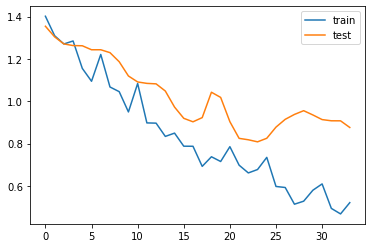

In [52]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend();

##  All Labels Model

In [54]:
files_label = y_df.file.to_list()
len(files_label)

2849

In [55]:
x = []
f_short=[]
y = []

for file in files_label:
    
    samples, sample_rate = librosa.load(f'{path_audio}/{file}', sr = 8000)
    label = y_df.loc[y_df.file==file, 'label'].values[0]
    
    if(len(samples) > 19680):
        samples=samples[:19680]
    if(len(samples) < 19680):
        samples = np.pad(samples, [0, 19680-len(samples)])

    x.append(samples)
    y.append(label)
        
f'{len(x)}/{len(files_label)} ({np.round(len(x) / len(files_label),2)*100}%) of files processed'

'2849/2849 (100.0%) of files processed'

In [56]:
le = LabelEncoder()
y = le.fit_transform(y)
y = np.array(y)

classes = list(le.classes_)
len(classes)

193

In [57]:
y = to_categorical(y)
y.shape

(2849, 193)

In [58]:
x = np.array(x).reshape(-1,19680,1)
x.shape

(2849, 19680, 1)

In [59]:
x_trn, x_val, y_trn, y_val = train_test_split(x, y, stratify=y, test_size=0.2, random_state=777)
x_trn.shape, x_val.shape, y_trn.shape, y_val.shape

((2279, 19680, 1), (570, 19680, 1), (2279, 193), (570, 193))

### CNN Model

In [60]:
inputs = Input(shape=(19680,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(classes), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 19680, 1)]        0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 19668, 8)          112       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 6556, 8)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 6556, 8)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 6546, 16)          1424      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2182, 16)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 2182, 16)         

In [61]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [62]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [63]:
history = model.fit(x_trn, y_trn ,epochs=100, callbacks=[es,mc], batch_size=128, validation_data=(x_val,y_val))

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 5.2558 - accuracy: 0.0070
Epoch 00001: val_loss improved from inf to 5.24075, saving model to best_model.hdf5
18/18 [==============================] - 16s 896ms/step - loss: 5.2558 - accuracy: 0.0070 - val_loss: 5.2408 - val_accuracy: 0.0088
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 5.1899 - accuracy: 0.0097
Epoch 00002: val_loss improved from 5.24075 to 5.17044, saving model to best_model.hdf5
18/18 [==============================] - 16s 872ms/step - loss: 5.1899 - accuracy: 0.0097 - val_loss: 5.1704 - val_accuracy: 0.0158
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 5.0977 - accuracy: 0.0145
Epoch 00003: val_loss improved from 5.17044 to 5.07250, saving model to best_model.hdf5
18/18 [==============================] - 16s 904ms/step - loss: 5.0977 - accuracy: 0.0145 - val_loss: 5.0725 - val_accuracy: 0.0158
Epoch 4/100
18/18 [==============================] - ETA: 0

Epoch 28/100
18/18 [==============================] - ETA: 0s - loss: 2.4153 - accuracy: 0.3971
Epoch 00028: val_loss did not improve from 4.52262
18/18 [==============================] - 16s 868ms/step - loss: 2.4153 - accuracy: 0.3971 - val_loss: 4.7480 - val_accuracy: 0.1088
Epoch 29/100
18/18 [==============================] - ETA: 0s - loss: 2.3185 - accuracy: 0.4186
Epoch 00029: val_loss did not improve from 4.52262
18/18 [==============================] - 17s 958ms/step - loss: 2.3185 - accuracy: 0.4186 - val_loss: 4.7260 - val_accuracy: 0.1123
Epoch 30/100
18/18 [==============================] - ETA: 0s - loss: 2.1922 - accuracy: 0.4432
Epoch 00030: val_loss did not improve from 4.52262
18/18 [==============================] - 17s 948ms/step - loss: 2.1922 - accuracy: 0.4432 - val_loss: 4.7685 - val_accuracy: 0.1123
Epoch 31/100
18/18 [==============================] - ETA: 0s - loss: 2.1460 - accuracy: 0.4520
Epoch 00031: val_loss did not improve from 4.52262
18/18 [=========

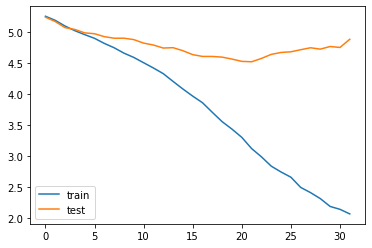

In [64]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend();